In [1]:
import warnings
import os
import json  # If loading presaved indexes using freeze_model
import shap
import time

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, LeaveOneOut, GridSearchCV
from sklearn import neighbors, metrics
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


warnings.filterwarnings("ignore")

shap.initjs()


# <u>Tentative de modelisation et prédiction de la variable : Intensité d'utilisation energetique</u>

## <u>1 : Modelisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Regressions lineaires</u>
### <u>1.2 : Potentielle méthode non lineaire : Regression KNN</u>

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>

<hr>

<b><u>Important :</u></b>

_note : La modélisation prend en compte la variable "electricity", celle ci représentant la majorité de la consommation energétique, on peut considérer qu'il y a une fuite de données. Neanmoins, la facilité d'obtention des relevés de consommation electrique des batiments (i.e. requete a la compagnie electrique) justifie, à mon sens, son utilisation dans la modélisation. Si neanmoins cette variable est considérée comme trop informative, il est possible de l'enlever du modèle en utilisant la methode d'instance `regression.drop_col(["scaled_Electricity(kWh)"])`._

<hr>

## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
general_file = "./data/seattle_std_scaled.csv"  # Used as backup


In [3]:
df_eui = pd.read_csv(general_file)
df_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
## Opening split

with open("./data/split_eui.json") as json_file:
    splits = json.load(json_file)


In [5]:
ids_train = splits["train"]
ids_test = splits["test"]


In [6]:
df_eui.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),BuildingAge,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_Nbhood_DOWNTOWN,ohe_Nbhood_EAST,ohe_Nbhood_GREATER DUWAMISH,ohe_Nbhood_LAKE UNION,ohe_Nbhood_MAGNOLIA / QUEEN ANNE,ohe_Nbhood_NORTH,ohe_Nbhood_NORTHEAST,ohe_Nbhood_NORTHWEST,ohe_Nbhood_SOUTHEAST,ohe_Nbhood_SOUTHWEST
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,95.0,1,12,60.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,26.0,1,11,61.0,0.855,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,96.0,1,10,56.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,96.0,1,11,27.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,94.0,1,9,48.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_eui.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'BuildingAge', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'EnergyStarCert', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_Ptype_Hospital',
       'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School', 'ohe_Ptype_Large Office',
       'ohe_Ptype_Mixed Use Property', 'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbh

In [8]:
# Target : target_SourceEUI(kWh/m2) :

droplist = [
    "target_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "scaled_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_eui.drop(columns=droplist)


In [9]:
eui_target = "target_SourceEUI(kWh/m2)"
eui_regression = Linear_reg(dataframe=df_model, target=eui_target)


In [10]:
# Forcing split : 

df_train_override = df_model[df_model.index.isin(ids_train)]
df_test_override = df_model[df_model.index.isin(ids_test)]


In [11]:
eui_regression.force_split(
    df_test_ovr=df_test_override,
    df_train_ovr=df_train_override
)


In [12]:
# Dropping the Cert (redundant)

eui_regression.drop_col(["EnergyStarCert"])


#### Execution : 
Parametres similaires à l'emission de GES, on ajustera au besoin: 
- Ridge = 0.1, 30, step 0.04
- Elastic Net = Alpha = Alpha_ridge = 0.1, 30, step 0.04, default L1 ratio
- Lasso Alpha = 0.01, 10, 0.02

In [13]:
alphas_ridge = np.arange(0.1, 30, 0.04)
alphas_elnet = np.arange(0.1, 30, 0.04)
alphas_lasso = np.arange(0.01, 6, 0.01)

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [14]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 6.933997040963732
Time used during predict = 0.00010620802640914917


Ridge: 

Ridge best Alpha : 0.7400000000000001
Time used during fit = 0.1457249999511987
Time used during predict = 7.325003389269114e-05


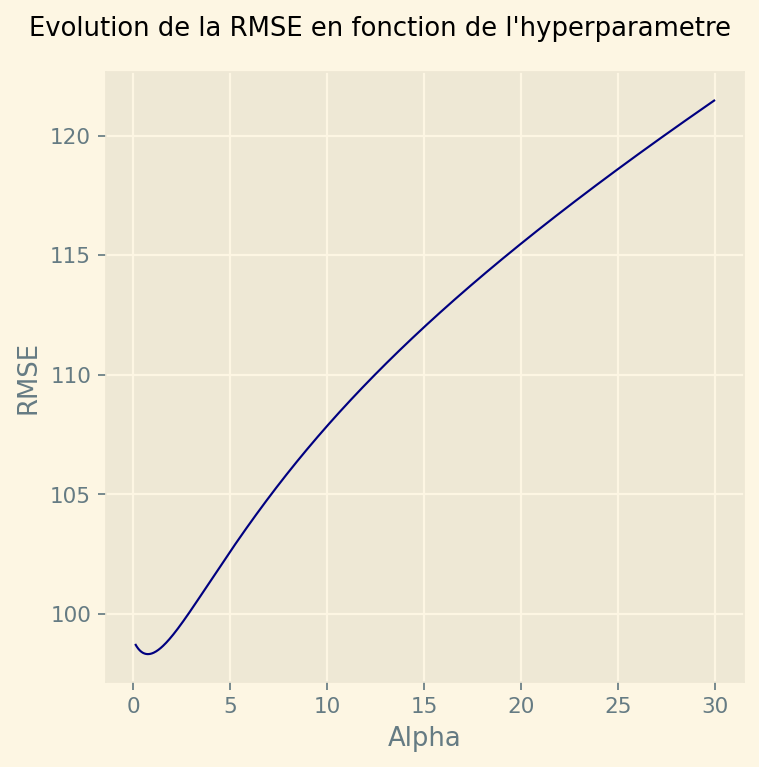

In [15]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.5700000000000001
Time used during fit = 0.36390408396255225
Time used during predict = 0.0006836249958723783


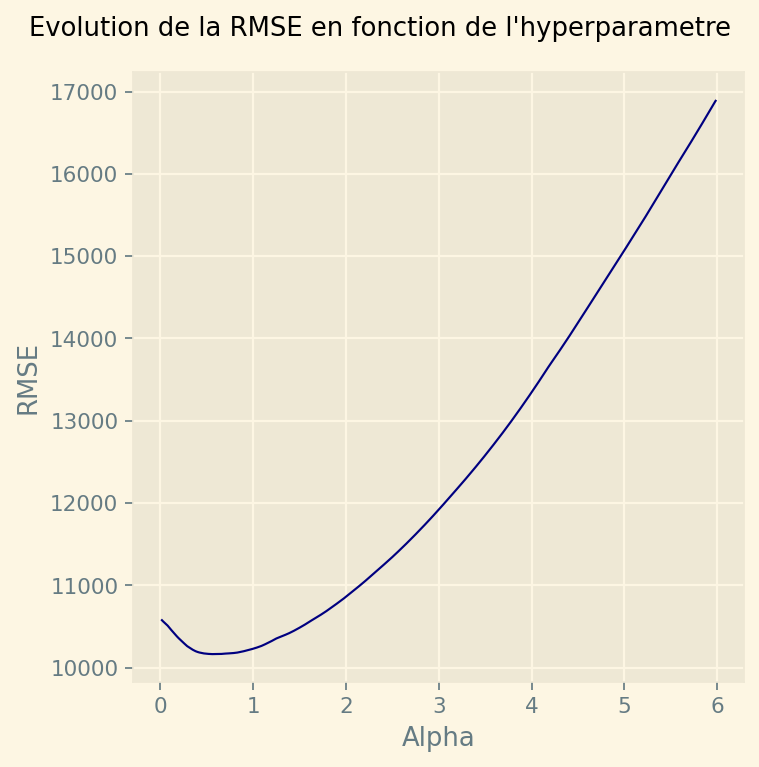

In [16]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [17]:
metrics_l1out_estar = eui_regression.format_all_metrics()

metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


##### <u>Observations : 1.1.a :</u>
- Les modèles sont tous gloabalement performants.
- Le modele Ridge semble etre le plus performant sur les données d'entrainement avec une baisse du score R2 entre l'execution sur les donnees d'entrainement et sur les donnees de test.
- OLS est tres stable, on remarque des scores plus faibles que les autres regressions mais le modele est le seul a exceder les performaces attendues lors du passage au test (R2 plus haut, RMSE plus faible)
- ElasticNet semble etre le moins bon des modeles avec une RMSE de +|- 149 kWh/m2 sur le jeu de test

<hr>



#### 1.1.b : Cross validation = RepeatedKfold (10 folds aleatoires, 3 repetitions, i.e 30 folds)

- On utilise exactement les memes parametres que lors de la validation croisee utilisant Leave One Out
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee
- Kfolds etant souvent beaucoup plus lourd a executer que Leave One Out, on attend de meilleurs scores mais des temps de traitement plus élevés

In [18]:
## Changing CV to RepeatedKfold :
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

eui_regression.common_parameters["cv"] = k_folds


In [19]:
# Same split, same parameters, except cv = kfolds :

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [20]:
metrics_kfold_estar = eui_regression.format_all_metrics()


In [21]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 42.19906891603023
Time used during predict = 0.00048162497114390135


In [22]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 0.66
Time used during fit = 18.49508366698865
Time used during predict = 5.6208111345767975e-05


In [23]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.54
Time used during fit = 2.318080500001088
Time used during predict = 0.0001159169478341937


In [24]:
print("# Metriques des regressions utilisant Kfold #")
metrics_kfold_estar


# Metriques des regressions utilisant Kfold #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


In [25]:
print("# Metriques des regressions utilisant Leave One Out #")
metrics_l1out_estar


# Metriques des regressions utilisant Leave One Out #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


##### Observations 1.1.b et comparaisons avec 1.1.a :

- Le temps d'execution est largement superieur, ce qui etait attendu
- La regression Ridge semble peut profiter de validation croisee par Kfold. Les performances sont extremement impressionantes sur le jeu d'entrainement (0.87 kWh/m2), mais il rentre dans les valeurs attendues (autour de 100kWh de RMSE) lors de son execution sur les donnees de test
- On peut questionner l'utilité de la validation par Kfold dans ce cas, meme si de tres faibles gains sont remarquables.
<br> 
<hr>
<br>
<b>Choix de Ridge Kfold :</b> <br>

- Le temps de fit est certes plus haut, mais une fois le modele entrainé, il predit les valeurs de test relativement precisement, et extremement rapidement.
- Elastic Net n'offre pas de gain significatif pour son temps d'entrainement largement superieur
- On analyse Ridge Kfold plus en details et c'est la regression principale qu'on utilisera pour comparer l'etape 1 à l'étape 2.

### <u>1.2 : Potentielle méthode non lineaire : Regression KNN</u>

Ici encore, le problème semble solvable en utilisant des methodes linéaires. Il est possible neanmoins d'appliquer, comme dans le cas de la modélisation sur les GàES, une regression par KNN pour verifier que d'autres methodes ne sont pas plus performantes.

In [26]:
X_train, X_test = eui_regression.X_train, eui_regression.X_test
y_train, y_test = eui_regression.y_train, eui_regression.y_test

neighbors_candidates = [5, 7, 9, 11, 13, 15, 17, 19]

knnr = neighbors.KNeighborsRegressor()

# Grid search

l1out = LeaveOneOut()

param_grid_knnr = {'n_neighbors':neighbors_candidates}

score = "neg_mean_squared_error"

# KNN regressors Setup

knn_reg_l1o = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=l1out,
    scoring=score
)

knn_reg_rkf = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=k_folds,
    scoring=score
)


In [27]:
knnr_l1o_fit_ts = time.perf_counter()

knn_reg_l1o.fit(
    X=X_train,
    y=y_train
)

knnr_l1o_fit_tf = time.perf_counter()

time_to_fit_knn_l1out = knnr_l1o_fit_tf - knnr_l1o_fit_ts

rmse_knnr_l1o = np.sqrt(abs(knn_reg_l1o.best_score_))
y_pred_train_l1o = knn_reg_l1o.predict(X_train)
r2_knnr_l1o = metrics.r2_score(y_true=eui_regression.y_train, y_pred=y_pred_train_l1o)


In [28]:
print(f"RMSE Regression KNN, Cross Val : Leave one out = {rmse_knnr_l1o}")
print(f"Score R2 Regression KNN, Cross Val : Leave one out = {r2_knnr_l1o}")
print(f"Temps fit : {time_to_fit_knn_l1out}")
print(f"Meilleur hyperparametre : {knn_reg_l1o.best_params_}")


RMSE Regression KNN, Cross Val : Leave one out = 175.54441493262067
Score R2 Regression KNN, Cross Val : Leave one out = 0.3832699079371096
Temps fit : 3.872959250002168
Meilleur hyperparametre : {'n_neighbors': 11}


In [29]:
knnr_rkf_fit_ts = time.perf_counter()

knn_reg_rkf.fit(
    X=X_train,
    y=y_train
)

knnr_rkf_fit_tf = time.perf_counter()

time_to_fit_knn_rkf = knnr_rkf_fit_tf - knnr_rkf_fit_ts

rmse_knnr_rkf = np.sqrt(abs(knn_reg_rkf.best_score_))
y_pred_train_rkf = knn_reg_rkf.predict(X_train)
r2_knnr_rkf = metrics.r2_score(y_true=eui_regression.y_train, y_pred=y_pred_train_l1o)


In [30]:
print(f"RMSE Regression KNN, Cross Val : Repeated KFolds = {rmse_knnr_rkf}")
print(f"Score R2 Regression KNN, Cross Val : Repeated KFolds = {r2_knnr_rkf}")
print(f"Temps fit : {time_to_fit_knn_rkf}")
print(f"Meilleur hyperparametre : {knn_reg_l1o.best_params_}")


RMSE Regression KNN, Cross Val : Repeated KFolds = 177.5771590856325
Score R2 Regression KNN, Cross Val : Repeated KFolds = 0.3832699079371096
Temps fit : 0.5589737500995398
Meilleur hyperparametre : {'n_neighbors': 11}


#### Observations sur KNN :
- Comme dans le cas des GàES, une methode de regression utilisant KNN n'est pas souhaitable. Le score R2 du modèle s'éffondre et l'erreur augmente grandement.
- Les modèles de regression linéaires semblent, dans ce cas et dans le cadre des modèles essayés, suffisamment precis et pertinents.
- Il n'est pas impossible qu'une autre méthode de regression non linéaire soit plus performante (Random Forest Regressor par exemple), mais le modèle Ridge validé par Repeated Kfolds se montre suffisamment satisfaisant pour justifier la non implémentation d'un méthode beaucoup plus lourde

## <u>2 : Etude de l'importance de la note Energy Star</u>


### <u>2.0 : Utilisation de SHAP</u> pour determiner l'importance des differentes variables sur la regression retenue lors de l'etape precedente :

- On identifiera quels sont les principales features qui entrent en compte lors de la modelisation
- On pourra voir si la variable Energy Star Score figure parmi les plus importantes features

In [31]:
target_and_cert = [eui_target, "EnergyStarCert"]

X_all = eui_regression.df_origin.drop(columns=target_and_cert).to_numpy()
X100 = shap.utils.sample(X_all, 100) # 100 instances for use as the background distribution

features = eui_regression.df_origin.drop(columns=target_and_cert).columns

explainer = shap.LinearExplainer(eui_regression.ridge_cv, X100, feature_names=features)
shap_values = explainer(X_all)


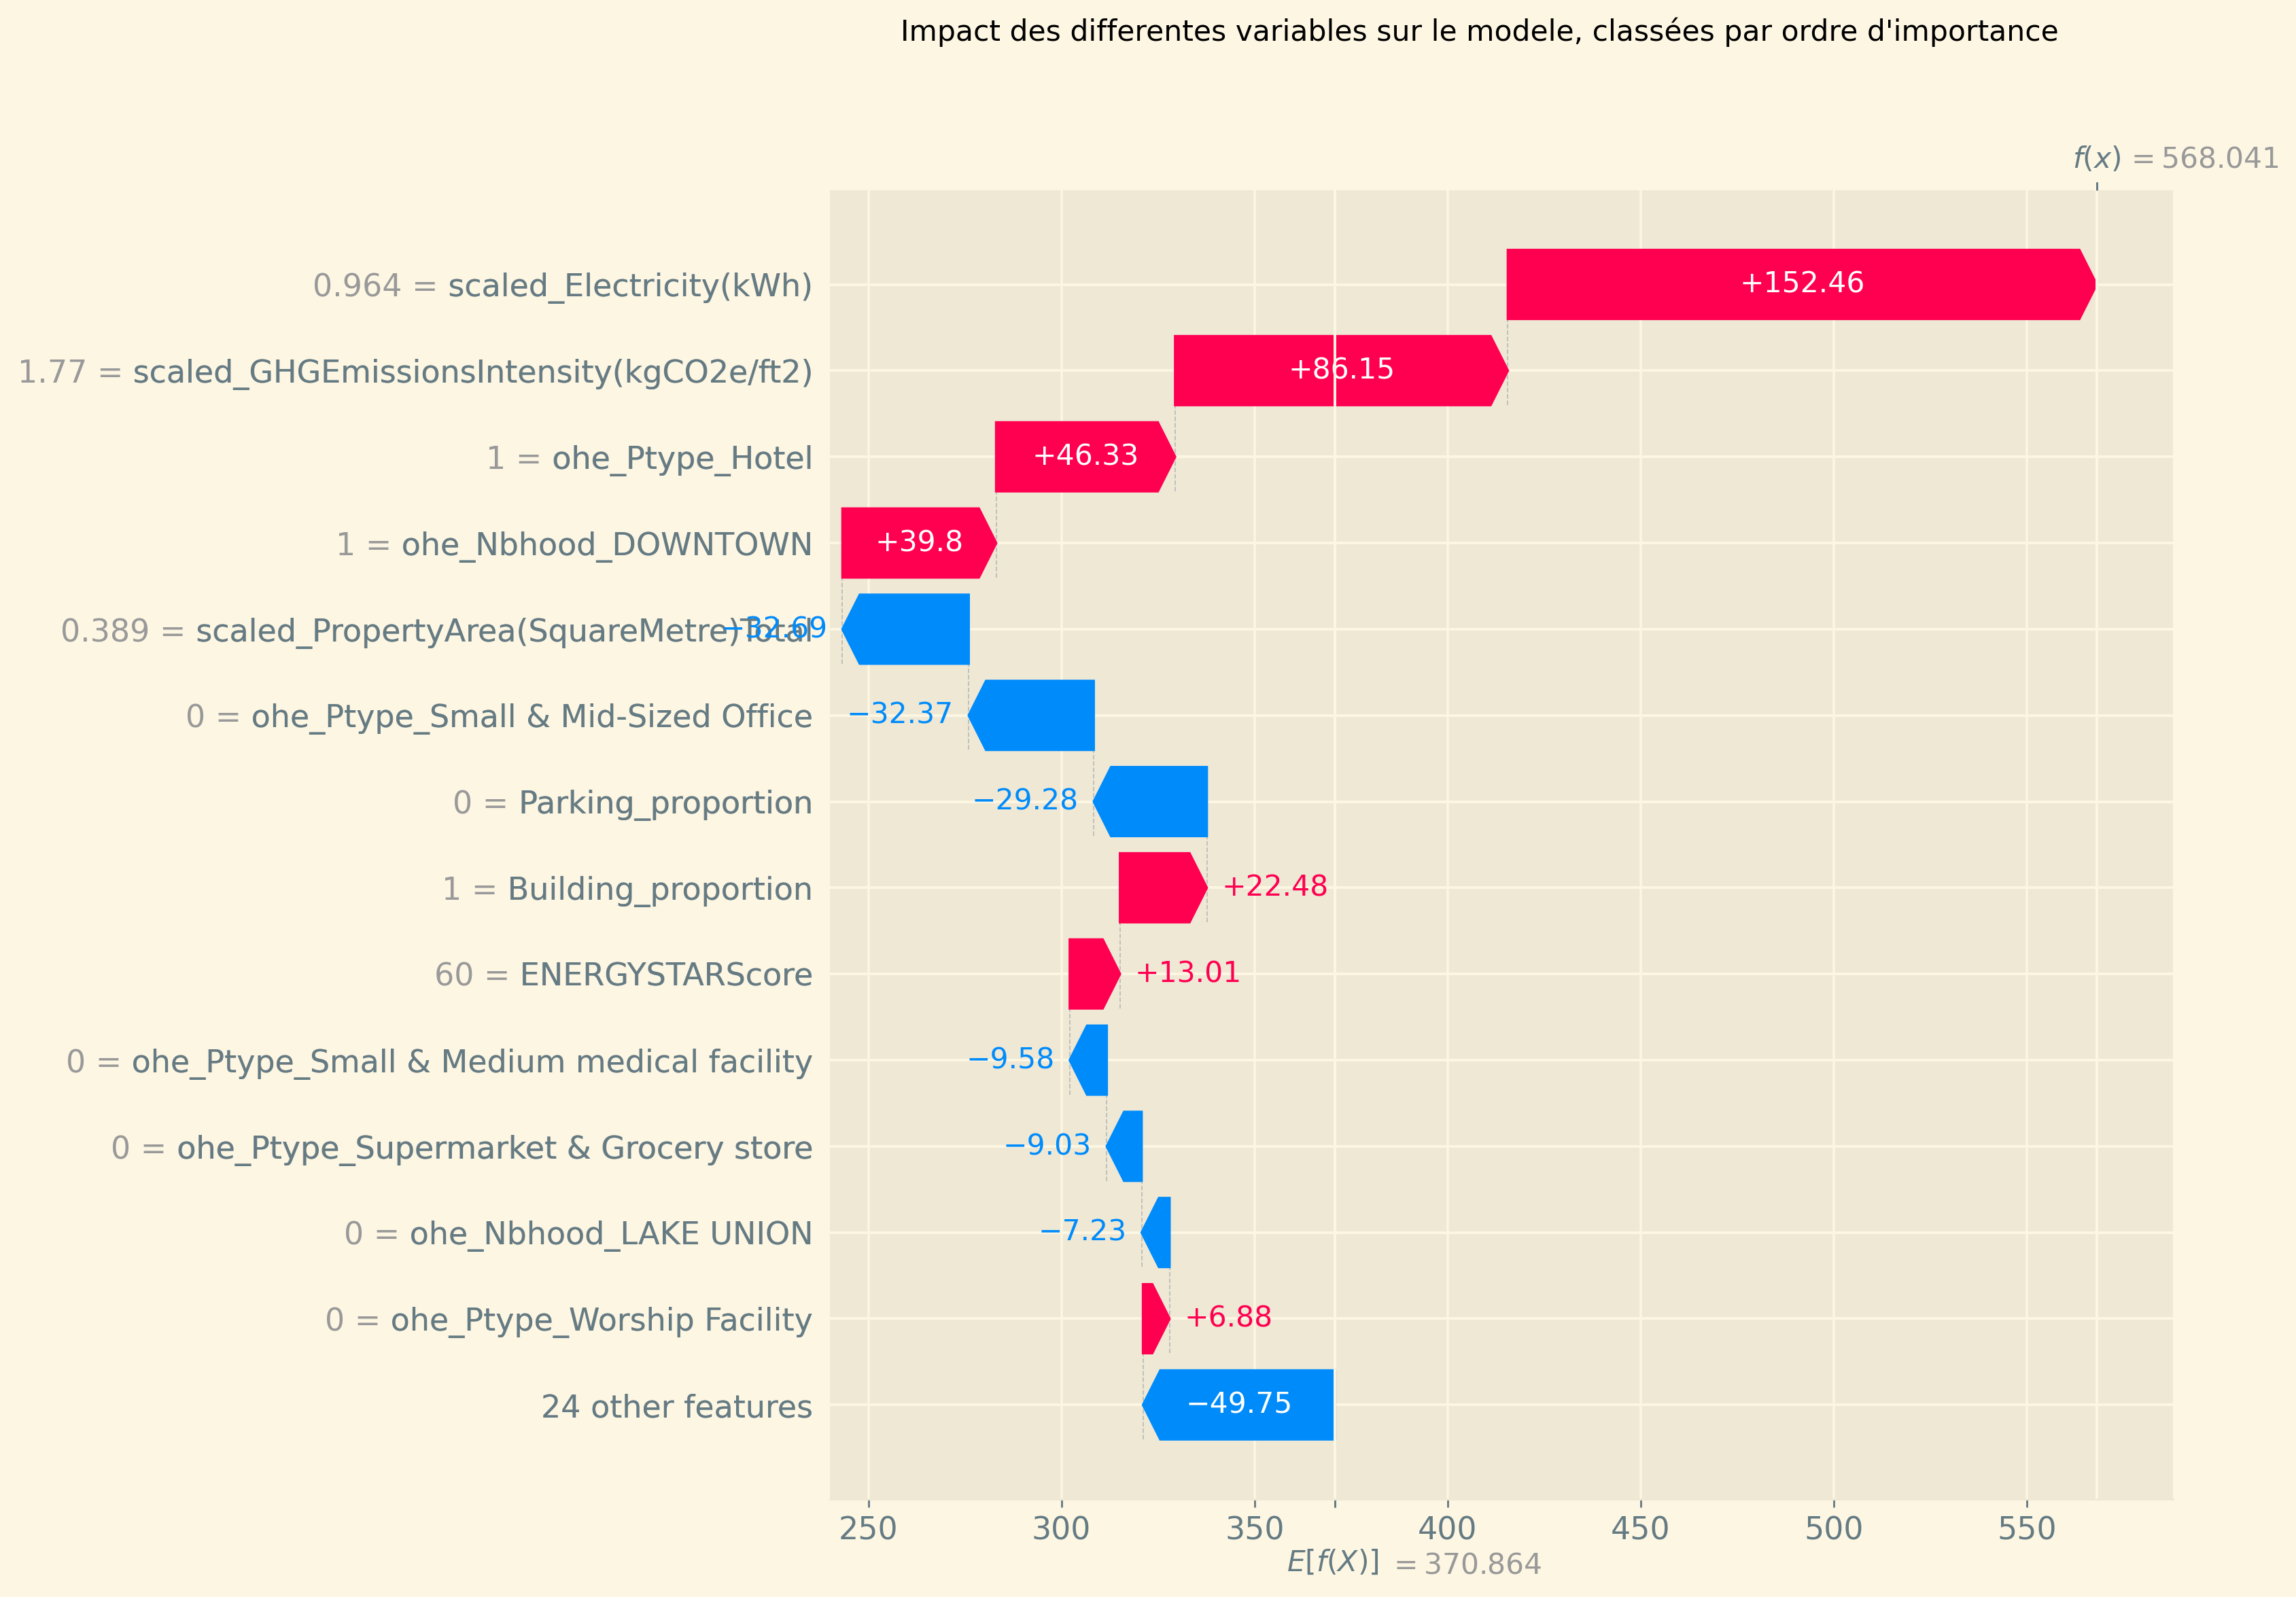

In [32]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=14, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


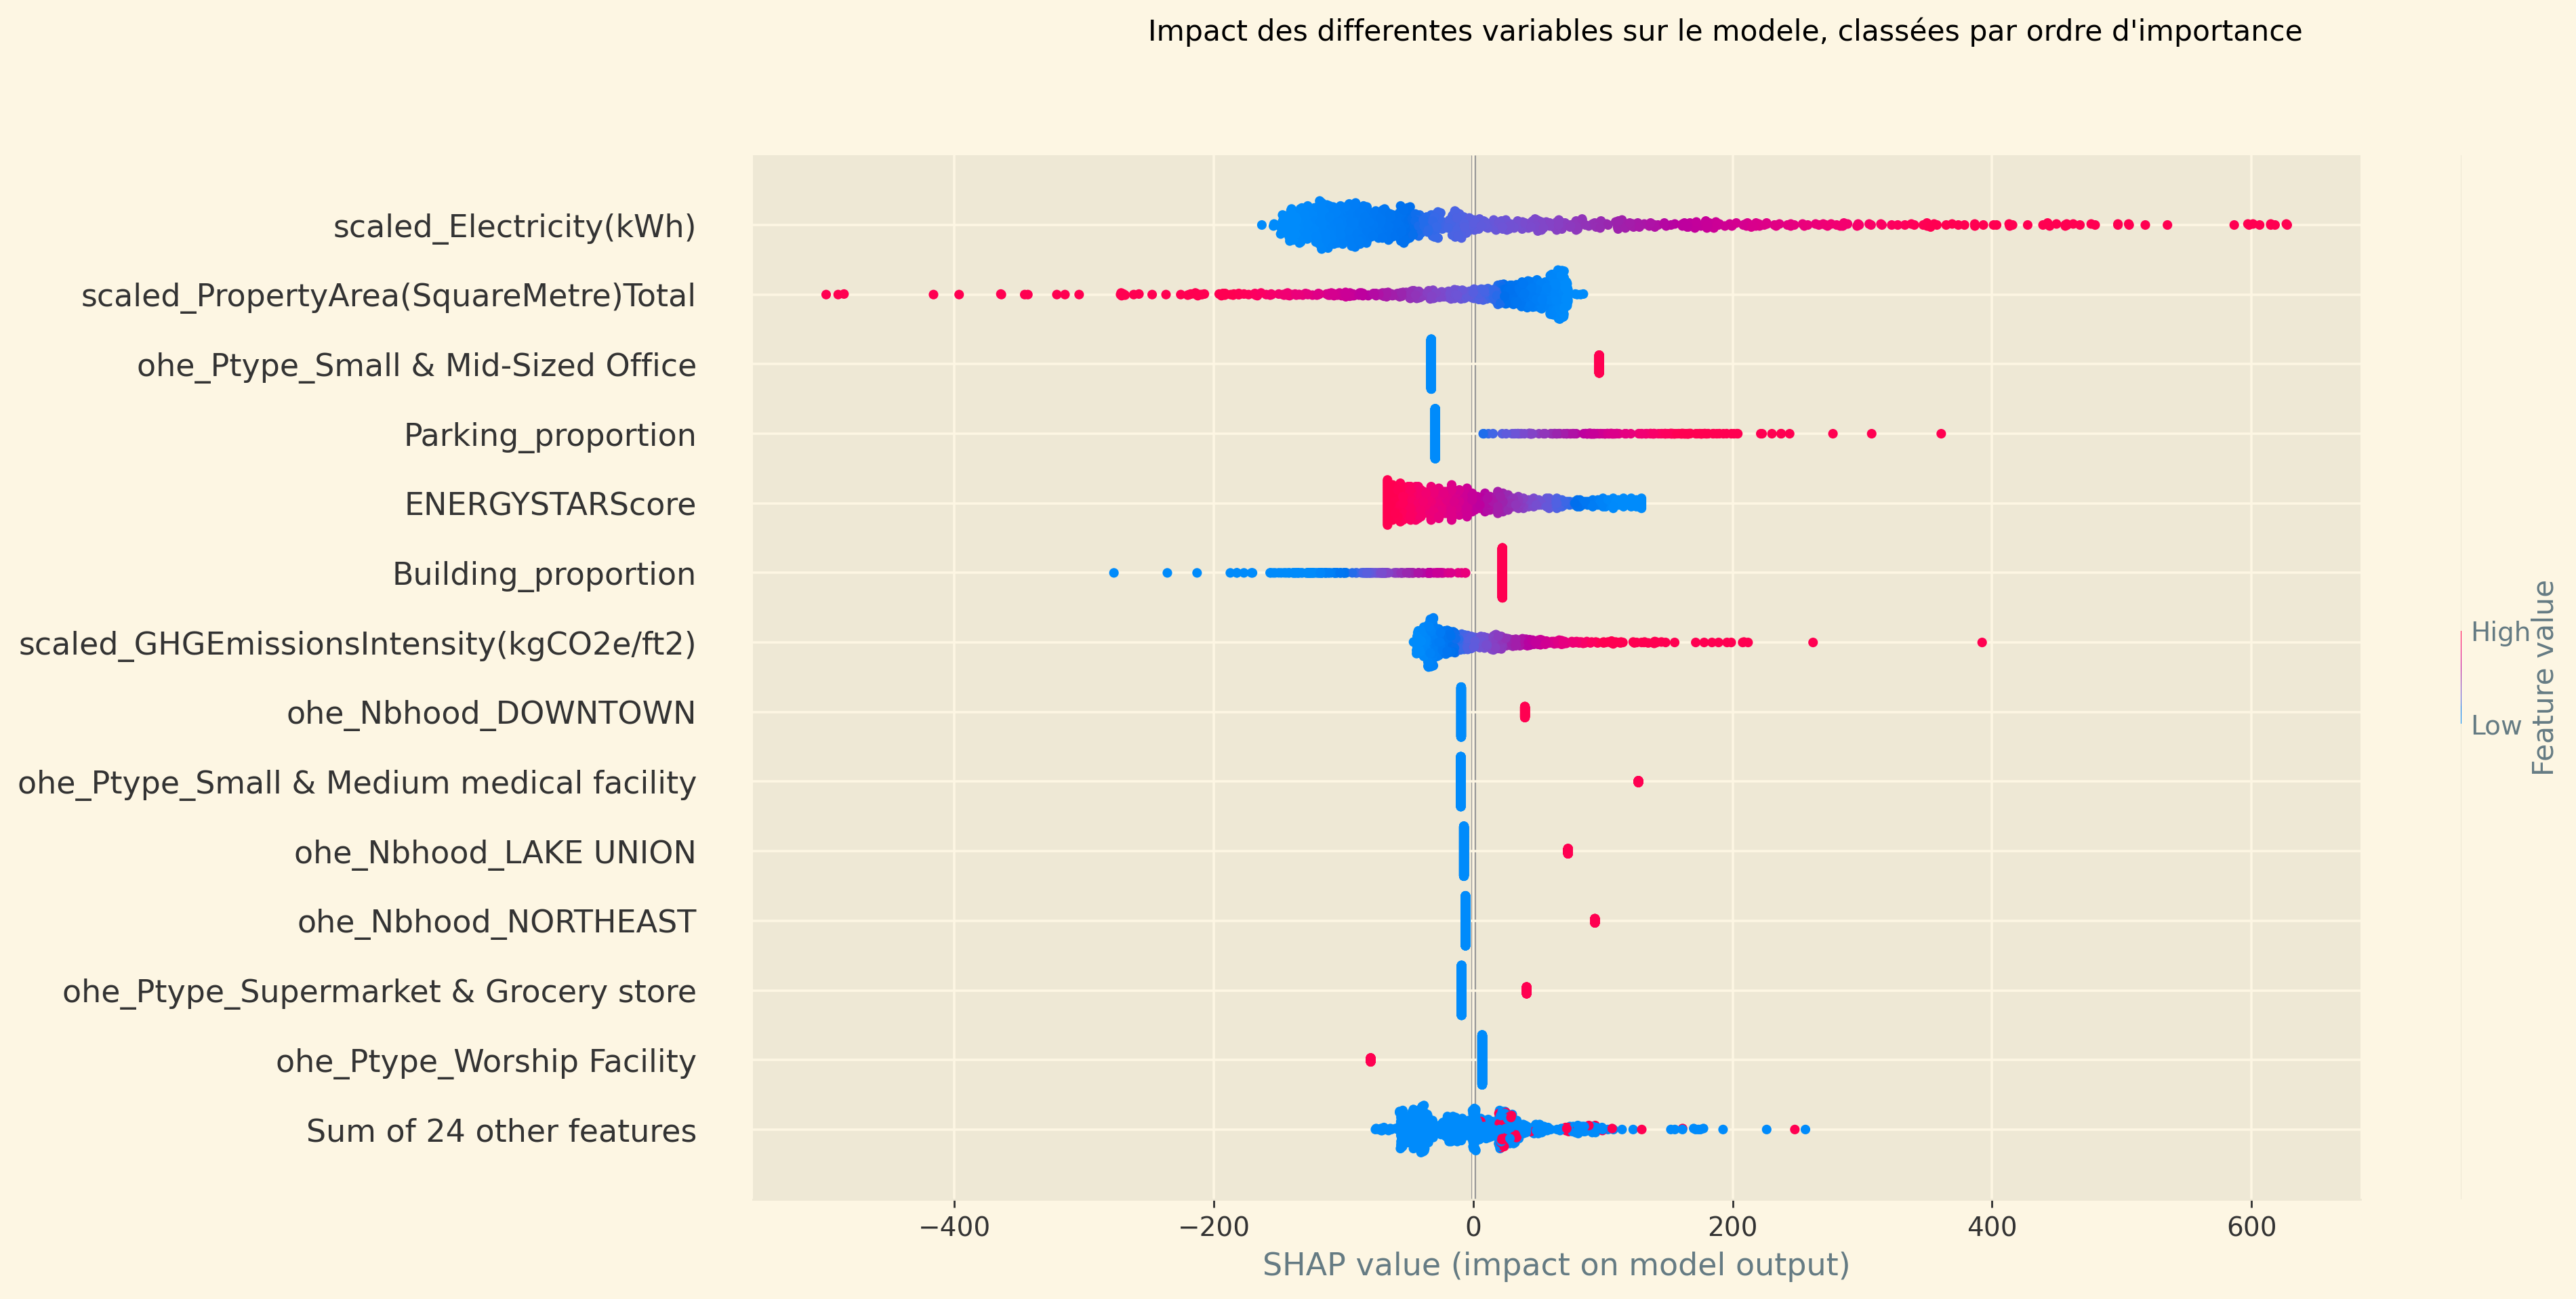

In [33]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


#### Observations 2.0 : 

- Energy Star Score semble etre une valeur très importante au modèle : le plot summary (n2) montre que plus sa valeur est basse, plus l'intensité d'utilisation energetique augmente. Des valeurs hautes du score ("bons" scores) sont corrélés avec une valeur de sortie faible.

### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


In [34]:
drop_col = ["ENERGYSTARScore", "EnergyStarCert"]

eui_regression.drop_col(col_list=drop_col)

eui_regression.common_parameters["cv"] = None


In [35]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [36]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 6.7894007079303265
Time used during predict = 0.0004022920038551092


Ridge: 

Ridge best Alpha : 1.3000000000000003
Time used during fit = 0.0885040839202702
Time used during predict = 6.374996155500412e-05


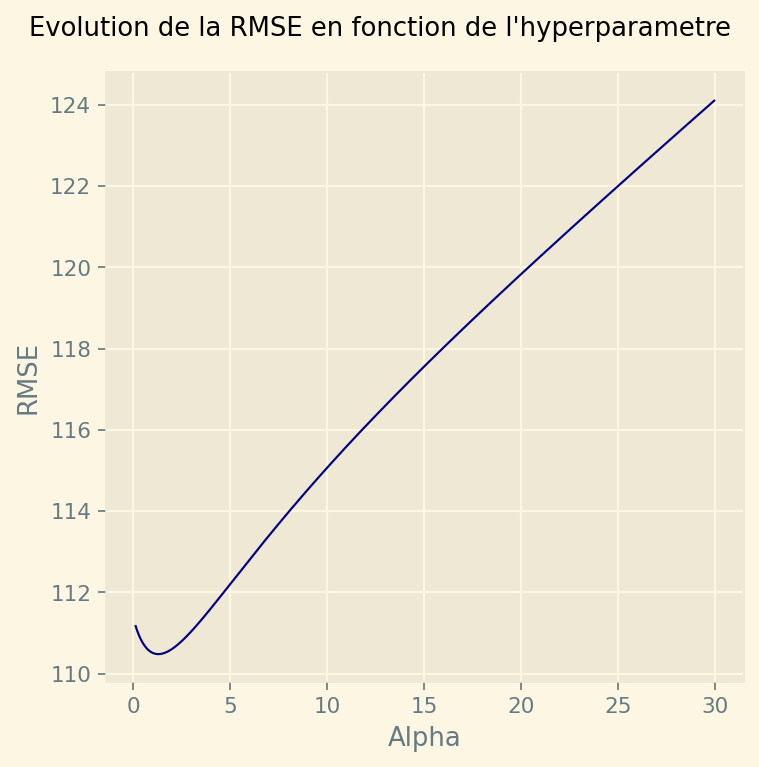

In [37]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.9500000000000001
Time used during fit = 0.32923541706986725
Time used during predict = 0.000627957982942462


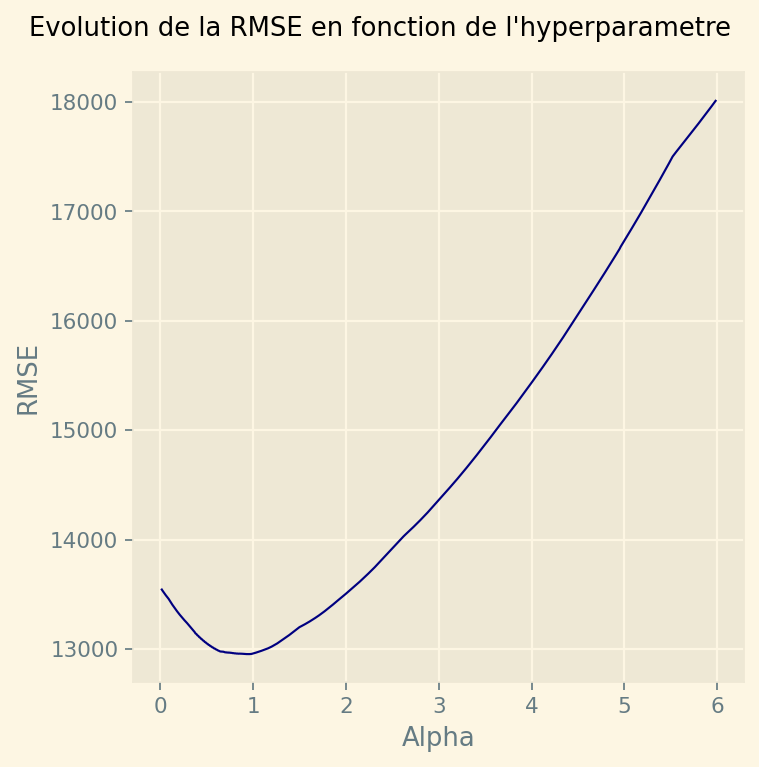

In [38]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [39]:
metrics_l1out_no_estar = eui_regression.format_all_metrics()

metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.530411,0.663871,110.482589,0.75338,113.814848,0.744595,215.538689,0.745782
Test,116.388233,0.666498,118.466156,0.654484,115.335066,0.672506,120.969609,0.639726
Test/Train,0.999,1.004,1.072,0.869,1.013,0.903,0.561,0.858


In [40]:
metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


#### heavy losses on all models
#### using kfold

In [41]:
eui_regression.common_parameters["cv"] = k_folds


In [42]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [43]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 40.451083458960056
Time used during predict = 0.00020237499848008156


In [44]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


Ridge: 

Ridge best Alpha : 1.1400000000000003
Time used during fit = 18.513972083106637
Time used during predict = 5.77080063521862e-05
Cannot use plot on ridge regression with CV not None, cf. sklearn doc on "store_cv_values" on RidgeCV


In [45]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 1.0
Time used during fit = 2.276102833915502
Time used during predict = 9.512505494058132e-05


In [46]:
metrics_kfold_no_estar = eui_regression.format_all_metrics()

metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.525722,0.694601,0.836113,0.754132,110.272552,0.743695,222.055113,0.745782
Test,116.388233,0.666498,118.149676,0.656327,115.43197,0.671956,120.969609,0.639726
Test/Train,1.044,0.96,141.308,0.87,1.047,0.904,0.545,0.858


In [47]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


#### heavy performances losses aswl

- Ici, contrairement a la modelisation de la prediction d'emission de GaES, la variable E* score semble très importante. On note de fortes baisses du score R2 de chaque modèle, et egalement une augmentation de l'erreur RMSE

#### Hypothèses :

- On sait que les batiments notés par EnergyStar sont qualifiés EnergyStar Certified s'ils ont une note superieure ou egale a 75.
- Est il possible de predire avec une haute confiance si un batiment aura une certification ou non ?
- Si oui, cette nouvelle statistique booleene aurait-elle un impact sur notre modele ? Si c'est le cas, il serait avantageux de tenter de predire ce score en utilisant des methode de classification. Cela permettrait d'avoir moins recours au calcul du score Per Se tout en retenant les benefices clairs apportés par cette variable

### 2.2 Utilisation de la certification :

In [48]:
eui_regression.reset_cols()
eui_regression.drop_col(["ENERGYSTARScore"])


Same parameters, its the 3rd time, you know the drill

In [49]:
# Let's fire up this bad boy : 
# Do me proud homes

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [50]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 40.88528170797508
Time used during predict = 0.0011225000489503145


In [51]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


Ridge: 

Ridge best Alpha : 0.9800000000000001
Time used during fit = 18.398572458070703
Time used during predict = 5.300005432218313e-05
Cannot use plot on ridge regression with CV not None, cf. sklearn doc on "store_cv_values" on RidgeCV


In [52]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


LASSO: 

LASSO best Alpha : 0.92
Time used during fit = 1.8846373340347782
Time used during predict = 0.0007971249287948012
Cannot use plot on ridge regression with CV not None, cf. sklearn doc on "store_cv_values" on RidgeCV


In [53]:
cert_metrics_l1out = eui_regression.format_all_metrics()

cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,105.863892,0.723692,0.852912,0.780444,104.545762,0.770964,221.960857,0.771302
Test,107.044804,0.717895,108.981196,0.707596,106.578629,0.720347,112.671364,0.687459
Test/Train,1.011,0.992,127.775,0.907,1.019,0.934,0.508,0.891


In [54]:
metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


In [55]:
metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.530411,0.663871,110.482589,0.75338,113.814848,0.744595,215.538689,0.745782
Test,116.388233,0.666498,118.466156,0.654484,115.335066,0.672506,120.969609,0.639726
Test/Train,0.999,1.004,1.072,0.869,1.013,0.903,0.561,0.858


In [56]:
eui_regression.common_parameters["cv"] = k_folds


eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [57]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 40.810737999971025
Time used during predict = 0.00010887498501688242


In [58]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 0.9800000000000001
Time used during fit = 17.49869029095862
Time used during predict = 0.00030579103622585535


In [59]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.92
Time used during fit = 1.8474298330256715
Time used during predict = 0.00023166602477431297


In [60]:
cert_metrics_kfolds = eui_regression.format_all_metrics()

cert_metrics_kfolds


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,105.863892,0.723692,0.852912,0.780444,104.545762,0.770964,221.960857,0.771302
Test,107.044804,0.717895,108.981196,0.707596,106.578629,0.720347,112.671364,0.687459
Test/Train,1.011,0.992,127.775,0.907,1.019,0.934,0.508,0.891


In [61]:
cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,105.863892,0.723692,0.852912,0.780444,104.545762,0.770964,221.960857,0.771302
Test,107.044804,0.717895,108.981196,0.707596,106.578629,0.720347,112.671364,0.687459
Test/Train,1.011,0.992,127.775,0.907,1.019,0.934,0.508,0.891


In [62]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


In [63]:
metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.525722,0.694601,0.836113,0.754132,110.272552,0.743695,222.055113,0.745782
Test,116.388233,0.666498,118.149676,0.656327,115.43197,0.671956,120.969609,0.639726
Test/Train,1.044,0.96,141.308,0.87,1.047,0.904,0.545,0.858


#### Observations :
- Les resultats sont encourageants. Il est evident que la certification, ou non, d'un batiment n'est pas aussi precise que son score mais on obtient un gain significatif par rapport aux modeles n'utilisant pas du tout le score EnergyStar.
- Si l'on garde l'exemple de Ridge, on obtient des resultats sensiblement plus optimistes. On perd certes en precision et on augmente l'erreur vis à vis du modele utilisant E* seul, mais cela peut etre un compromis interessant.
- On peut etudier l'importance de la feature avec la meme methode (shap) utilisee lors des precedents exemples. On s'attend a la voir contribuer substantiellement au modele.

In [64]:
target_and_score = [eui_target, "ENERGYSTARScore"]

X_all_cert = eui_regression.df_origin.drop(columns=target_and_score).to_numpy()
X100 = shap.utils.sample(X_all_cert, 100) # 100 instances for use as the background distribution

features_cert = eui_regression.df_origin.drop(columns=target_and_score).columns

explainer = shap.LinearExplainer(eui_regression.ridge_cv, X100, feature_names=features_cert)
shap_values = explainer(X_all_cert)


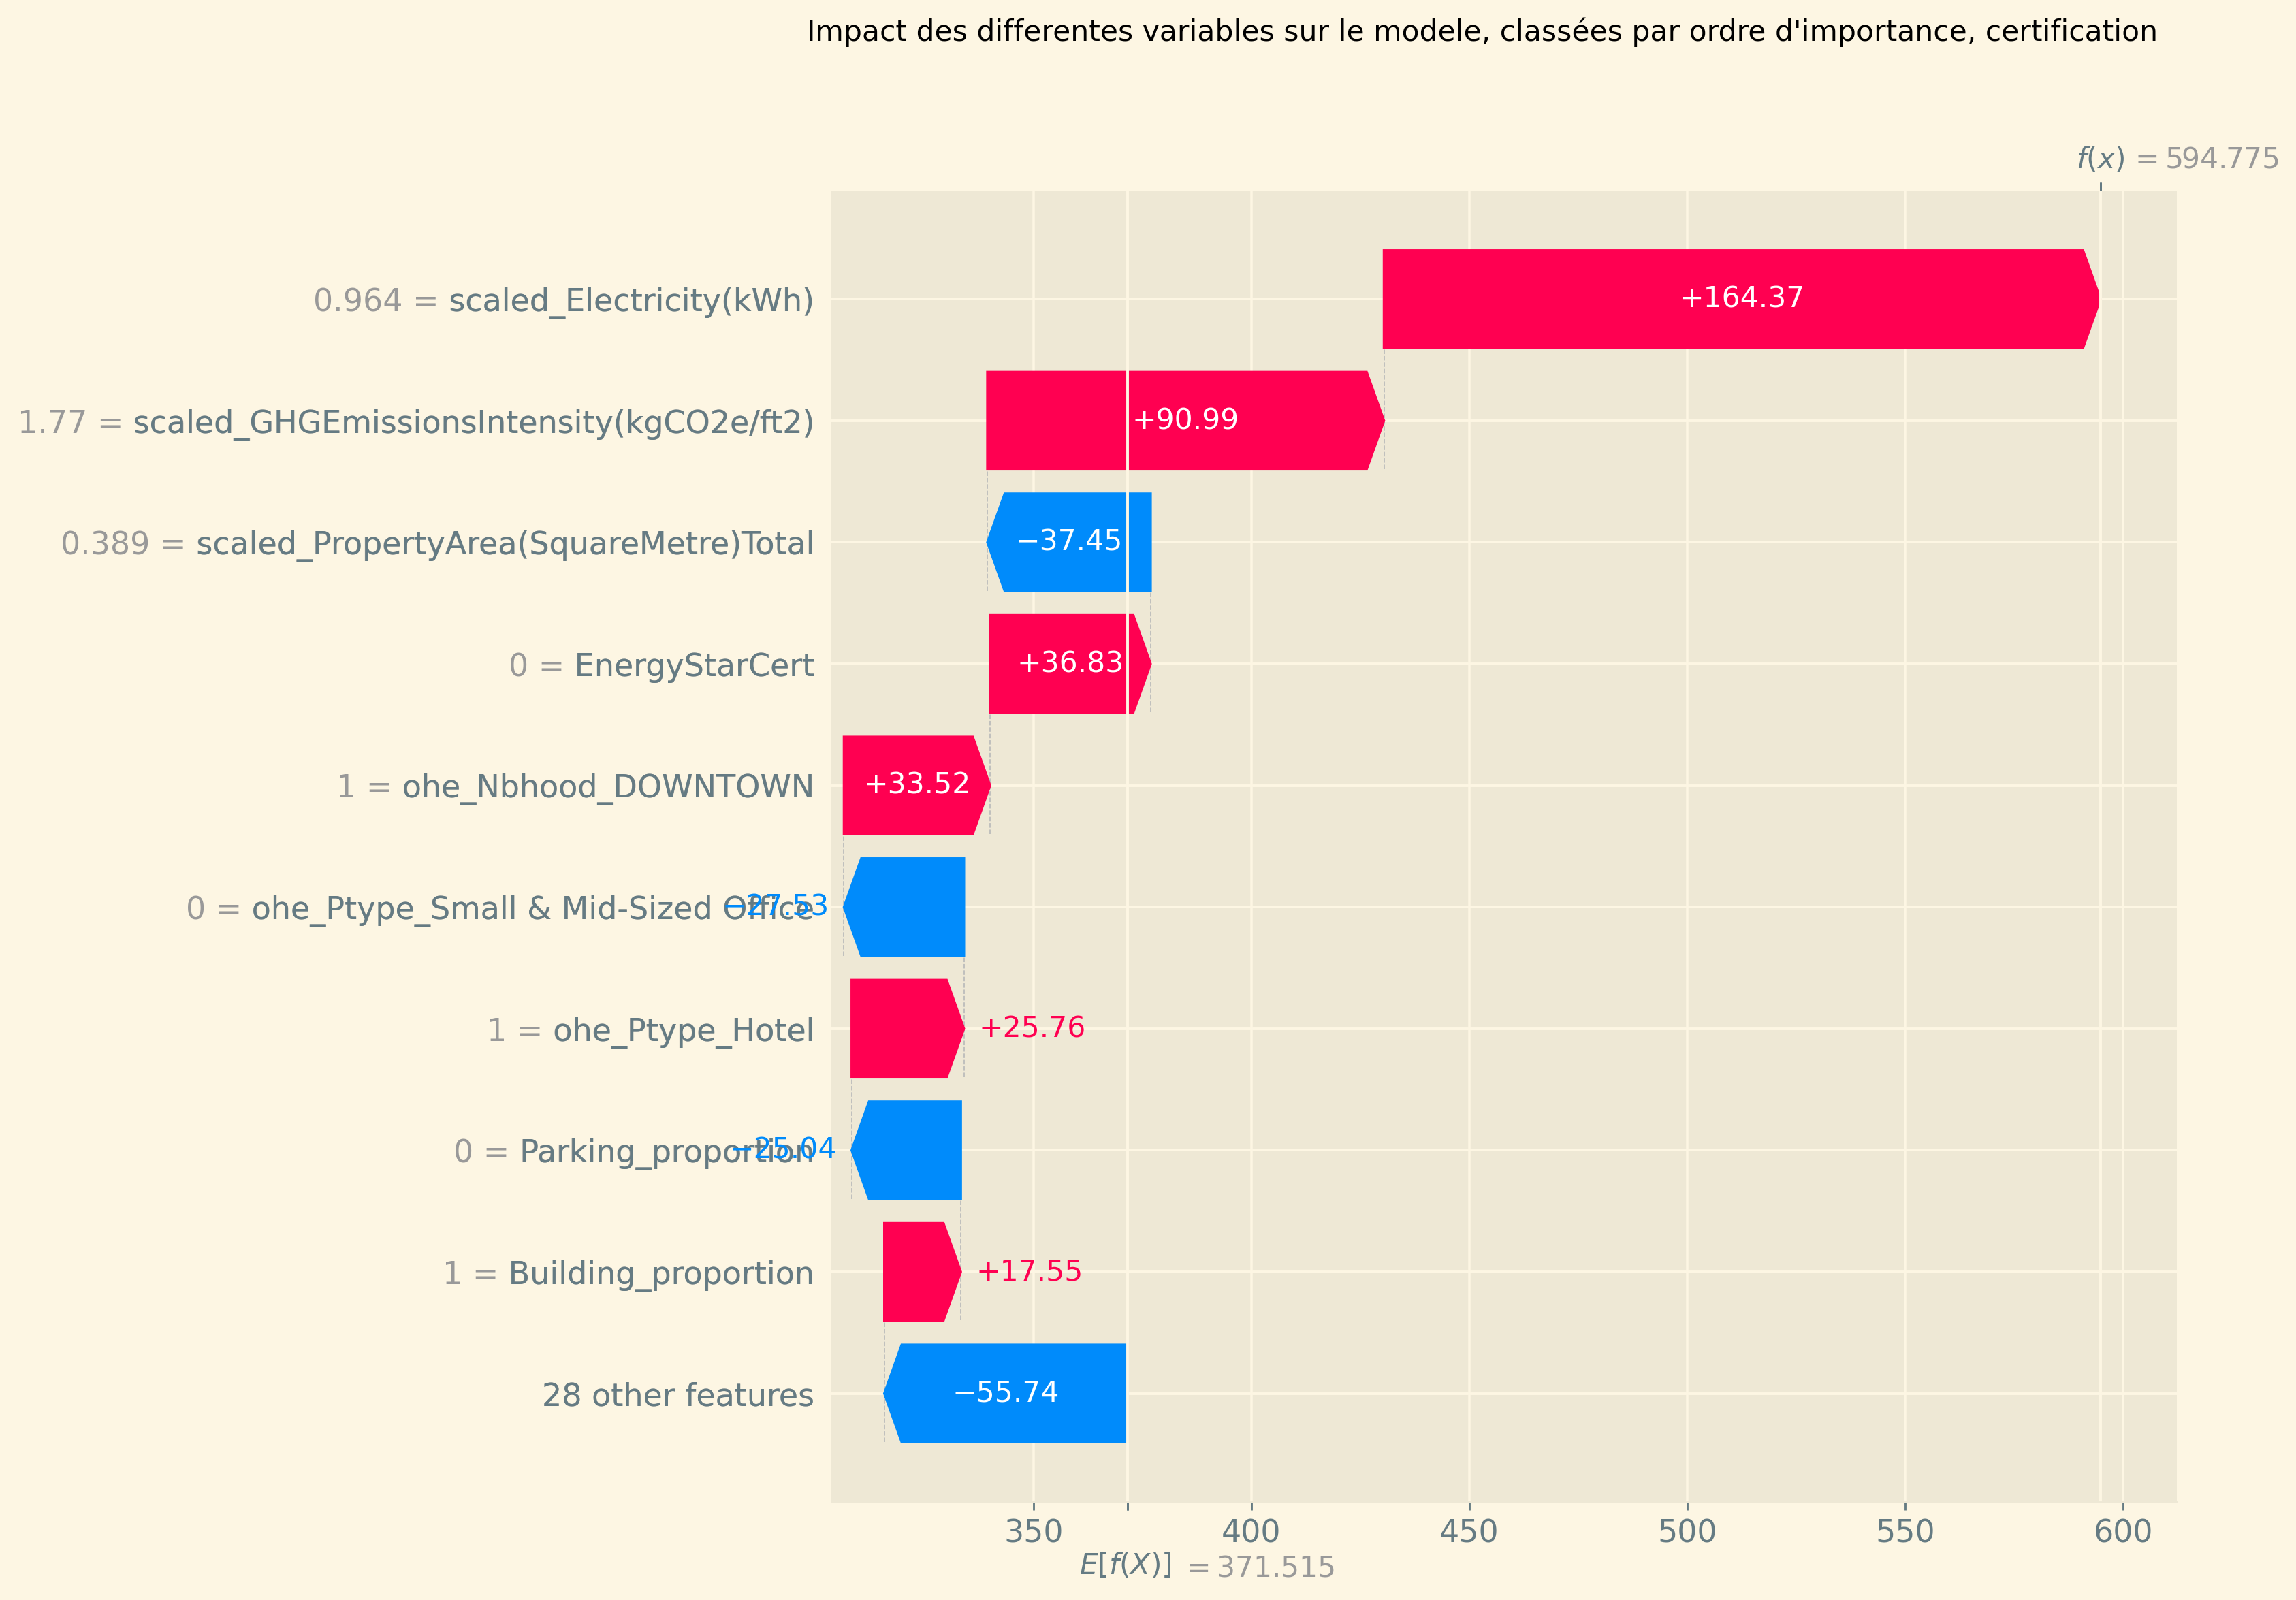

In [65]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=10, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


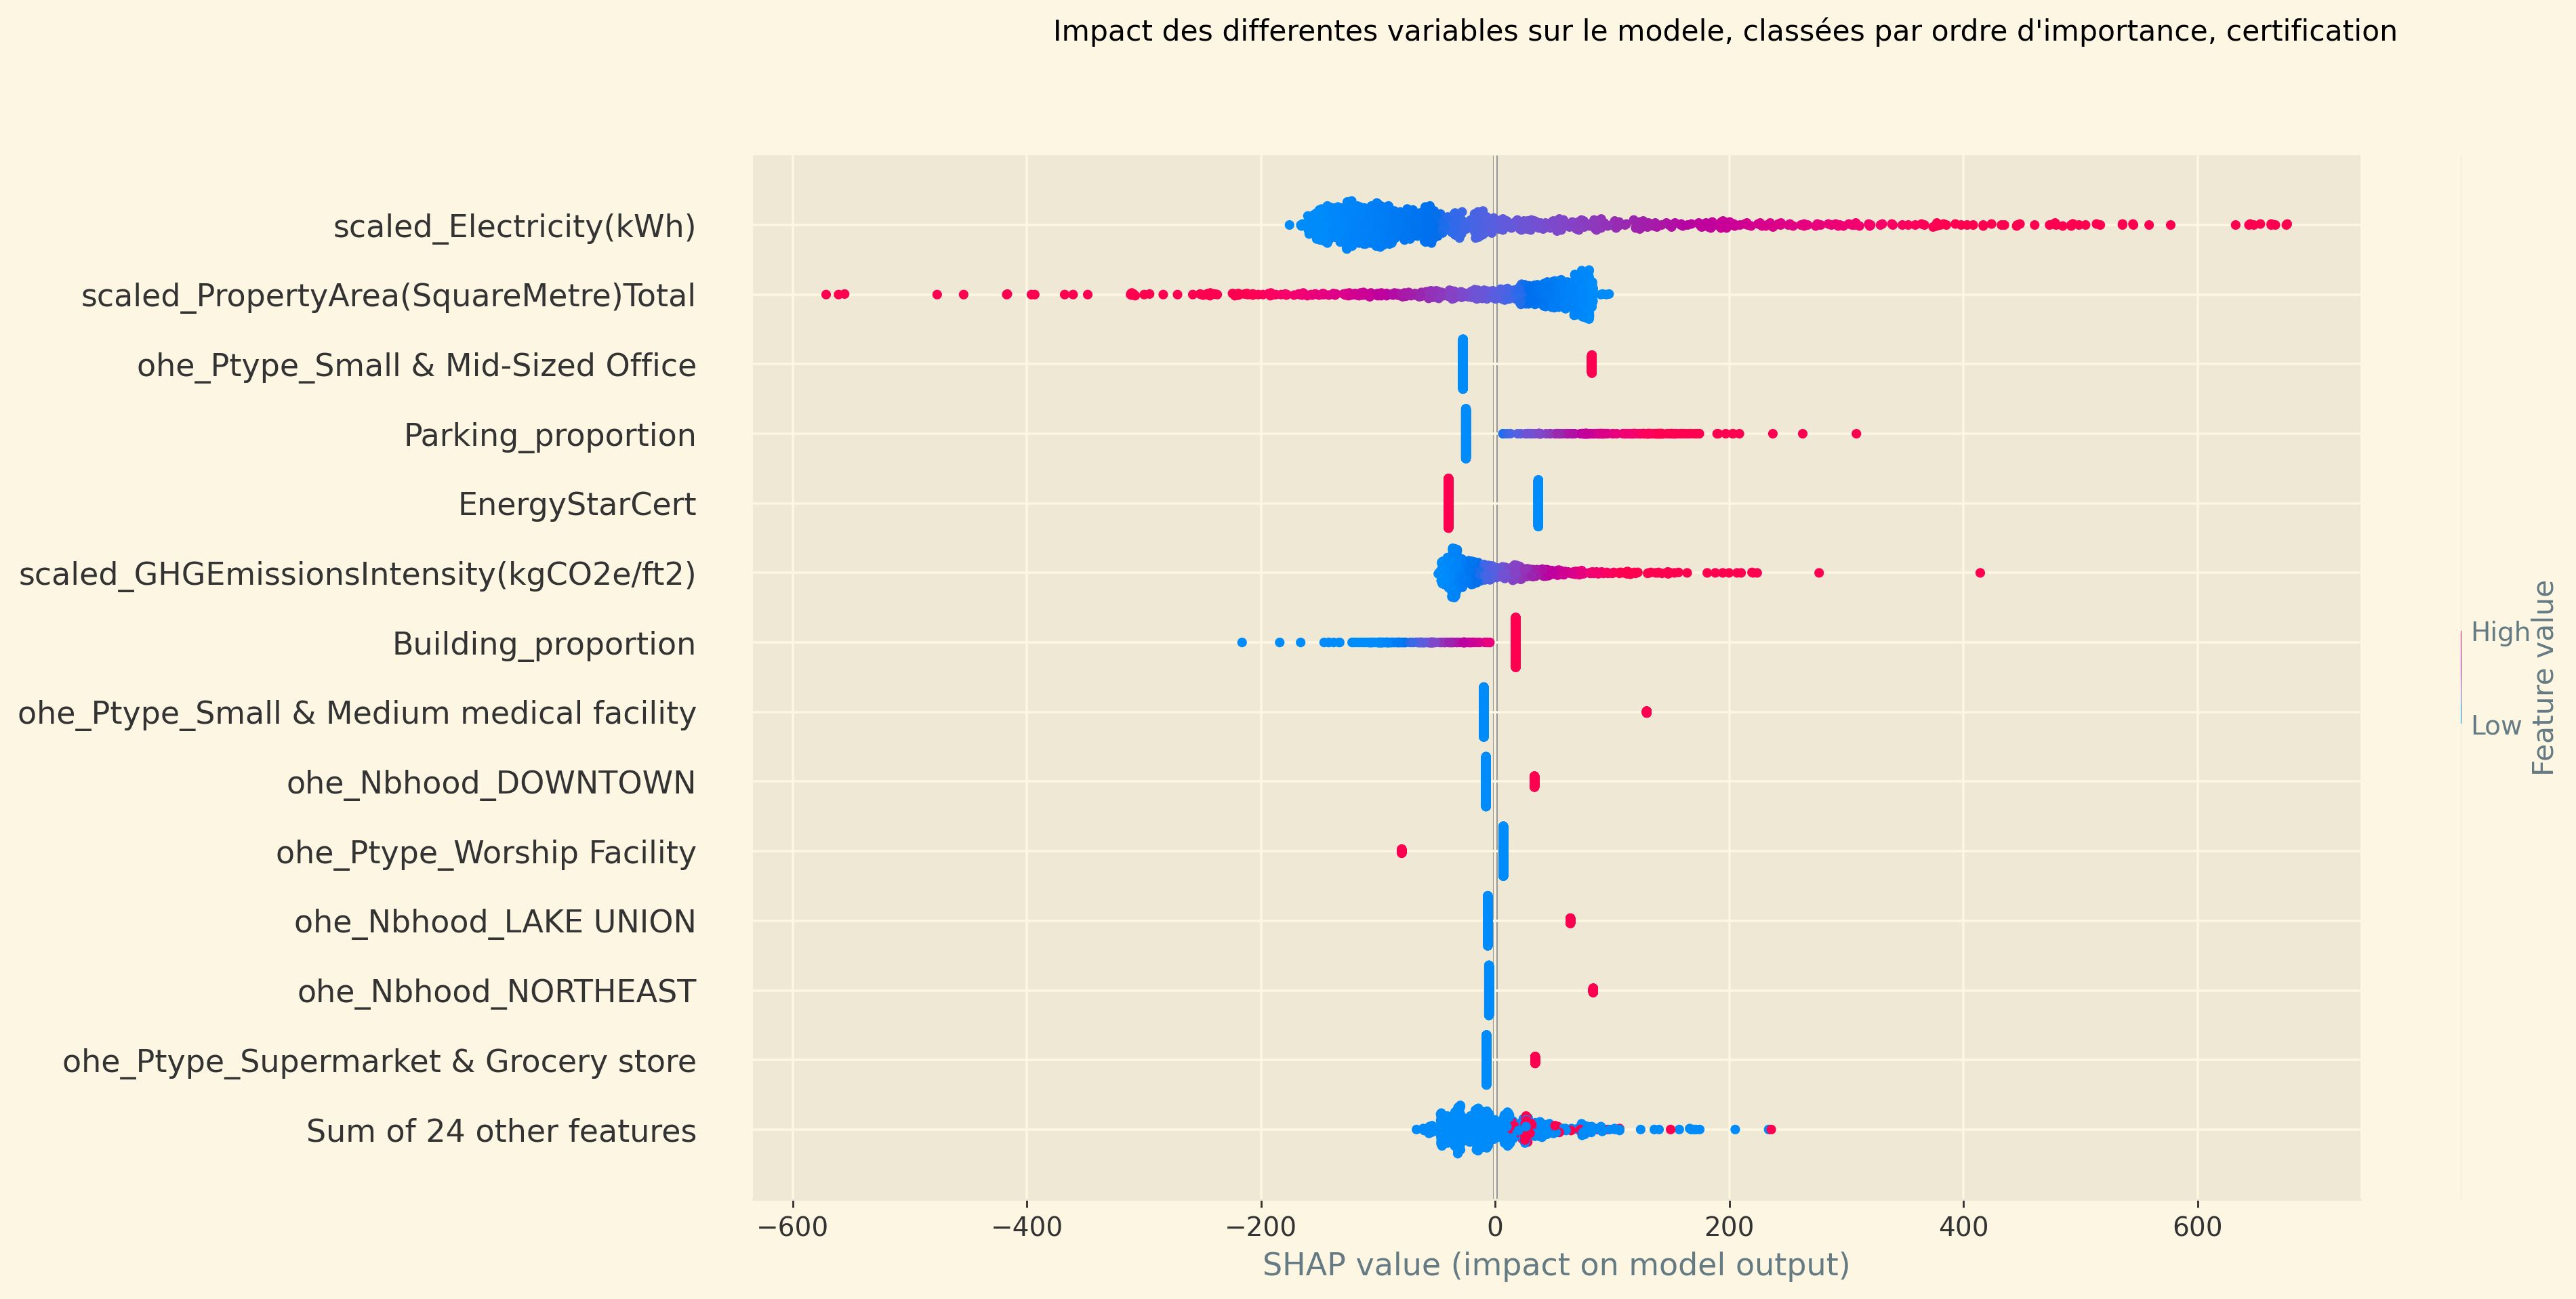

In [66]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


### Observations sur l'hypothese et ouverture vers un autre probleme. Conclusion générale.

- L'hypothèse selon laquelelle la certification, ou non, d'un batiment apporte une contribution sembable en terme d'impact à celle de la Note Per Se.
- Les resultats sont particulierement interessants dans la mesure ou l'on passe d'une note sur 100 à une valeur binaire.
- Cependant, un autre probleme se pose : Nous avons pu etablir la certification des batiments en connaissant a priori leurs notes. L'idée est d'essayer de moins s'appuyer sur cette note - En clair, une nouvelle problematique emerge : Est il possible de predire si un batiment sera certifié ou non, en se basant sur les variables connues.
    - Dans le cas ou cela est possible est suffisamment precis, cette alternative est un bon compromis entre les pertes de performances consequentes dues à l'elimination totale d'E*.
    - Dans le cas ou cela est impossible ou trop peu precis. On recommandera, au possible, d'effectuer les calculs de ce score. La difference "avec/sans" est trop importante et le score beneficie bien trop au modele pour s'en passer.
- Dans l'ensemble, l'utilisation de Ridge, ici en utilisant Kfold (repetition 3 fois de 10 folds) est recommandée : c'est le modèle le plus precis même si quelque peu inconstant.